In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import math
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas
from gluonts.mx import SimpleFeedForwardEstimator, Trainer
from gluonts.evaluation import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.dataset.pandas import PandasDataset

#### Read dataset

In [2]:
EVdata = pd.read_csv("stationAggDaytoDay2011_2020May12.csv", header = 0, index_col = 0)

In [3]:
EVdata.set_index('StartDate', inplace=True)

In [4]:
EVdata

,Station Name,counts,Energy (kWh),GHG Savings (kg),Gasoline Savings (gallons)
StartDate,,,,,
2011-10-13,BRYANT 1,2,8.262052,3.470,1.037
2011-10-14,BRYANT 1,1,6.259466,2.629,0.786
2011-10-15,BRYANT 1,1,4.622894,1.942,0.580
2011-10-17,BRYANT 1,1,4.023361,1.690,0.505
2011-10-18,BRYANT 1,1,15.474944,6.499,1.942
...,...,...,...,...,...
2020-12-25,WEBSTER 3,1,9.897000,4.157,1.242
2020-12-26,WEBSTER 3,1,10.359000,4.351,1.300
2020-12-29,WEBSTER 3,3,37.291000,15.662,4.680


##### TestData: one time series

In [5]:
testData= EVdata.loc[EVdata["Station Name"] == "HAMILTON 1", ["counts", "Energy (kWh)"]]

In [6]:
testData = testData.rename(columns = {"Energy (kWh)": "target"})

In [7]:
testData["item_id"] = "HAMILTON 1"

In [8]:
testData.head()

,counts,target,item_id
StartDate,,,
2011-07-29,1,6.249457,HAMILTON 1
2011-07-30,5,28.978653,HAMILTON 1
2011-07-31,3,37.209163,HAMILTON 1
2011-08-01,1,5.041244,HAMILTON 1
2011-08-02,1,4.197217,HAMILTON 1


In [52]:
def one_or_multiple_time_series(data, station_name_list, target, item_id, fields):
    '''
    purpose: 
        1. select one or multiple time series
        2. change the column names

    input variables:
        data: input dataframe
        station_name_list: the station name list (each one is a time series)
        target: the target variable name
        item_id: id of each time series, here it means station name list
        fields: input fields from the input data
    '''
    testData= data.loc[EVdata["Station Name"] == station_name_list, fields]
    testData = testData.rename(columns = {target: "target"})
    testData["item_id"] = item_id
    return testData

In [53]:
data = EVdata
station_name_list = "HAMILTON 1"
target = "Energy (kWh)"
item_id = "HAMILTON 1"
fields = ["counts", "Energy (kWh)"]

testData = one_or_multiple_time_series(EVdata, station_name_list, target, item_id, fields)
testData.head()


,counts,target,item_id
StartDate,,,
2011-07-29,1,6.249457,HAMILTON 1
2011-07-30,5,28.978653,HAMILTON 1
2011-07-31,3,37.209163,HAMILTON 1
2011-08-01,1,5.041244,HAMILTON 1
2011-08-02,1,4.197217,HAMILTON 1


#### Handle missing data

In [25]:
ds = PandasDataset.from_long_dataframe(testData, target="target", item_id="item_id", freq = "D")

In [28]:
max_end = max(testData.groupby("item_id").apply(lambda _df: _df.index[-1]))
dfs_dict = {}
for item_id, gdf in testData.groupby("item_id"):
    new_index = pd.date_range(gdf.index[0], end=max_end, freq="1D")
    dfs_dict[item_id] = gdf.reindex(new_index).drop("item_id", axis=1)
    dfs_dict[item_id][np.isnan(dfs_dict[item_id])] = 0
print(dfs_dict)

ds = PandasDataset(dfs_dict, target="target")
counts = dfs_dict["HAMILTON 1"].loc[:, "counts"].to_numpy()

{'HAMILTON 1':             counts     target
2011-07-29     1.0   6.249457
2011-07-30     5.0  28.978653
2011-07-31     3.0  37.209163
2011-08-01     1.0   5.041244
2011-08-02     1.0   4.197217
...            ...        ...
2020-10-30     3.0  25.440000
2020-10-31     2.0  15.122000
2020-11-01     2.0  44.383000
2020-11-02     0.0   0.000000
2020-11-03     1.0   6.545000

[3386 rows x 2 columns]}


In [50]:
next(iter(ds))

{'start': Period('2011-07-29', 'D'),
 'target': array([ 6.249457, 28.978653, 37.209163, ..., 44.383   ,  0.      ,
         6.545   ]),
 'item_id': 'HAMILTON 1'}

In [54]:
counts

array([1., 5., 3., ..., 2., 0., 1.])

#### Add multiple features

##### Number of counts

In [31]:
train_val_test_split = [0.7, 0.2, 0.1]
train_length = math.floor(next(iter(ds))["target"].shape[0]*train_val_test_split[0])
validation_length = math.floor(next(iter(ds))["target"].shape[0]*train_val_test_split[1])
prediction_length = math.floor(next(iter(ds))["target"].shape[0]*train_val_test_split[2])

freq = "1D"
train_start = pd.Period('2011-07-29', freq = freq)

In [55]:
train_length, validation_length, prediction_length

(2370, 677, 338)

In [33]:
from gluonts.dataset.field_names import FieldName

In [34]:
next(iter(ds))["target"].shape

(3386,)

In [35]:
next(iter(ds))["target"][: -prediction_length].shape

(3048,)

##### Temporal variables

In [36]:
from gluonts.time_feature import (
    day_of_week,
    day_of_month,
    day_of_year,
    week_of_year,
    month_of_year,
)

In [37]:
from gluonts.time_feature.holiday import (
   squared_exponential_kernel,
   SpecialDateFeatureSet,
   CHRISTMAS_DAY,
   CHRISTMAS_EVE
)

In [38]:
holidat_set = SpecialDateFeatureSet([CHRISTMAS_EVE, CHRISTMAS_DAY])

In [39]:
start_date = testData.index[0]
end_date = testData.index[-1]
start_date, end_date

(Timestamp('2011-07-29 00:00:00'), Timestamp('2020-11-03 00:00:00'))

In [40]:
date_indices = pd.date_range(
    start = start_date,
    end = end_date,
    freq = 'D'
)

In [41]:
day_of_week_variable = day_of_week(date_indices)
day_of_month_variable = day_of_month(date_indices)
day_year_variable = day_of_year(date_indices)
week_of_year_variable = week_of_year(date_indices)
month_of_year_variable = month_of_year(date_indices)

#### Use train and split

In [42]:
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [counts, dayofweek, monthofyear],
        }
        for (target, start, counts, dayofweek, monthofyear) in zip(
            next(iter(ds))["target"][: train_length].reshape(1, next(iter(ds))["target"][: train_length].shape[0]),
            [next(iter(ds))["start"]],
            counts[: train_length].reshape(1, counts[: train_length].shape[0]),
            day_of_week_variable[: train_length].reshape(1, day_of_week_variable[: train_length].shape[0]),
            month_of_year_variable[: train_length].reshape(1, month_of_year_variable[: train_length].shape[0])
        )
    ],
    freq=freq,
)

In [56]:
val_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [counts, dayofweek, monthofyear],
        }
        for (target, start, counts, dayofweek, monthofyear) in zip(
            next(iter(ds))["target"][: -prediction_length].reshape(1, next(iter(ds))["target"][: -prediction_length].shape[0]),
            [next(iter(ds))["start"]],
            counts[: -prediction_length].reshape(1, counts[: -prediction_length].shape[0]),
            day_of_week_variable[: -prediction_length].reshape(1, day_of_week_variable[: -prediction_length].shape[0]),
            month_of_year_variable[: -prediction_length].reshape(1, month_of_year_variable[: -prediction_length].shape[0])
        )
    ],
    freq=freq,
)

In [46]:
test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [counts, day_of_week_variable, month_of_year_variable],
        }
        for (target, start, counts, dayofweek, monthofyear) in zip(
            next(iter(ds))["target"].reshape(1, next(iter(ds))["target"].shape[0]),
            [next(iter(ds))["start"]],
            counts.reshape(1, counts.shape[0]),
            day_of_week_variable.reshape(1, day_of_week_variable.shape[0]),
            month_of_year_variable.reshape(1, month_of_year_variable.shape[0])
        )
    ],
    freq=freq,
)

In [57]:
train_ds

[{'target': array([ 6.249457, 28.978653, 37.209164, ..., 36.259   , 35.569   ,
         36.203   ], dtype=float32),
  'start': Period('2011-07-29', 'D'),
  'feat_dynamic_real': array([[ 1.        ,  5.        ,  3.        , ...,  5.        ,
           4.        ,  4.        ],
         [ 0.16666667,  0.33333334,  0.5       , ...,  0.33333334,
           0.5       , -0.5       ],
         [ 0.04545455,  0.04545455,  0.04545455, ..., -0.5       ,
          -0.5       , -0.5       ]], dtype=float32)}]

In [58]:
val_ds

[{'target': array([ 6.249457, 28.978653, 37.209164, ...,  6.799   , 17.977   ,
         12.798   ], dtype=float32),
  'start': Period('2011-07-29', 'D'),
  'feat_dynamic_real': array([[1.        , 5.        , 3.        , ..., 1.        , 4.        ,
          2.        ],
         [0.16666667, 0.33333334, 0.5       , ..., 0.16666667, 0.33333334,
          0.5       ],
         [0.04545455, 0.04545455, 0.04545455, ..., 0.4090909 , 0.4090909 ,
          0.5       ]], dtype=float32)}]

In [49]:
test_ds

[{'target': array([ 6.249457, 28.978653, 37.209164, ..., 44.383   ,  0.      ,
          6.545   ], dtype=float32),
  'start': Period('2011-07-29', 'D'),
  'feat_dynamic_real': array([[ 1.        ,  5.        ,  3.        , ...,  2.        ,
           0.        ,  1.        ],
         [ 0.16666667,  0.33333334,  0.5       , ...,  0.5       ,
          -0.5       , -0.33333334],
         [ 0.04545455,  0.04545455,  0.04545455, ...,  0.4090909 ,
           0.4090909 ,  0.4090909 ]], dtype=float32)}]

#### Visualize the dataset

In [62]:
train_entry = next(iter(train_ds))
train_series = to_pandas(train_entry)
train_series

2011-07-29     6.249457
2011-07-30    28.978653
2011-07-31    37.209164
2011-08-01     5.041244
2011-08-02     4.197217
                ...    
2018-01-18    41.178001
2018-01-19    55.083000
2018-01-20    36.258999
2018-01-21    35.569000
2018-01-22    36.202999
Freq: D, Length: 2370, dtype: float32

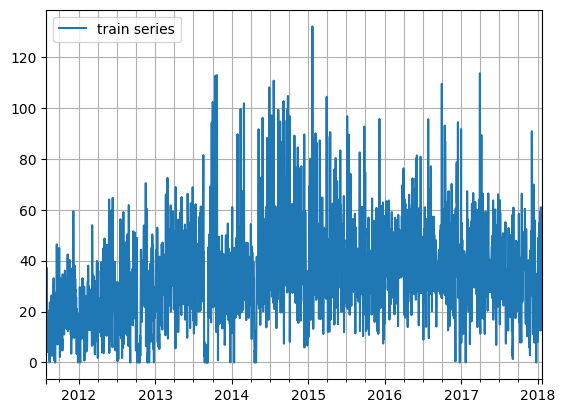

In [63]:
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

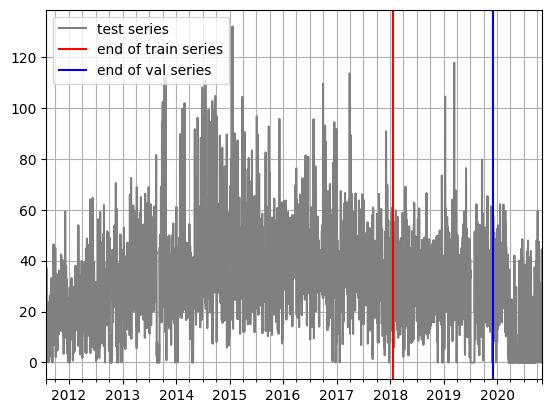

In [70]:
val_entry = next(iter(val_ds))
val_series = to_pandas(val_entry)

test_entry = next(iter(test_ds))
test_series = to_pandas(test_entry)
test_series.plot(color = "grey")
plt.axvline(train_series.index[-1], color="red")  # end of train dataset
plt.axvline(val_series.index[-1], color="blue")  # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series", "end of val series"], loc="upper left")
plt.show()

In [71]:
print(
    f"Length of forecasting window in test dataset: {prediction_length}"
)
print(f"Recommended prediction horizon: {prediction_length}")
print(f"Frequency of the time series: {freq}")

Length of forecasting window in test dataset: 338
Recommended prediction horizon: 338
Frequency of the time series: 1D


In [72]:
train_entry = next(iter(train_ds))
[k for k in train_entry.keys()]

['target', 'start', 'feat_dynamic_real']

In [73]:
test_entry = next(iter(test_ds))
[k for k in test_entry.keys()]

['target', 'start', 'feat_dynamic_real']

#### Train and prediction

##### Simple feed forward estimator

In [74]:
from gluonts.mx.trainer.callback import TrainingHistory

In [75]:
# defining a callback, which will log the training loss for each epoch
history = TrainingHistory()

In [115]:
simple_feed_forward_estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[50], ## default: 50
    prediction_length=prediction_length,
    batch_normalization = False, ## default: false
    mean_scaling = True, ## default: true
    context_length=100,
    trainer=Trainer(
        ctx="cpu", 
        epochs=20, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=20
    ),
)

##### MQCNN estimator

In [77]:
from gluonts.mx import MQCNNEstimator, Trainer

In [78]:
mqcnn_estimator = MQCNNEstimator(
    freq = freq,
    prediction_length=prediction_length,
    use_feat_dynamic_real=True,
    # context_length=100, ## Default: 4 * prediction_length
    trainer=Trainer(
        ctx="cpu", 
        epochs=20, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=10
    ),
)

##### MQRNN estimator

In [79]:
from gluonts.mx import MQRNNEstimator, Trainer

In [80]:
mqrnn_estimator = MQRNNEstimator(
    freq = freq,
    prediction_length=prediction_length,
    # context_length=100, ## Default: 4 * prediction_length
    trainer=Trainer(
        ctx="cpu", 
        epochs=20, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=10
    ),
)

##### DeepAR estimator

In [81]:
from gluonts.mx import DeepAREstimator, Trainer

In [109]:
deepAR_estimator = DeepAREstimator(
    freq = freq,
    prediction_length = prediction_length,
    use_feat_dynamic_real=True,
    trainer=Trainer(
        ctx="cpu", 
        epochs=20, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### DeepVAR estimator

In [83]:
from gluonts.mx import DeepVAREstimator, Trainer

In [84]:
deepVAR_estimator = DeepVAREstimator(
    freq = freq,
    prediction_length = prediction_length,
    use_feat_dynamic_real=True,
    target_dim= 1,
    trainer=Trainer(
        ctx="cpu", 
        epochs=20, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### LSTNet

In [85]:
from gluonts.mx import LSTNetEstimator, Trainer

In [86]:
lstnet_estimator = LSTNetEstimator(
    num_series = 1,
    prediction_length = prediction_length,
    ar_window = 10,
    channels = 1,
    context_length = 20,
    skip_size = 1,
    trainer=Trainer(
        ctx="cpu", 
        epochs=20, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Temporal fusion transformer

In [87]:
from gluonts.mx import TemporalFusionTransformerEstimator, Trainer

In [88]:
tft_estimator = TemporalFusionTransformerEstimator(
    freq = freq,
    prediction_length = prediction_length,
    hidden_dim = 10,
    trainer=Trainer(
        ctx="cpu", 
        epochs=20, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Transformer estimator

In [89]:
from gluonts.mx import TransformerEstimator, Trainer

In [90]:
transformer_estimator = TransformerEstimator(
    freq = freq,
    prediction_length = prediction_length,
    use_feat_dynamic_real=True,
    context_length = 100,
    trainer=Trainer(
        ctx="cpu", 
        epochs=20, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Deepfactor estimator

In [135]:
from gluonts.mx import DeepFactorEstimator, Trainer

In [285]:
deepFactor_estimator = TransformerEstimator(
    freq = freq,
    prediction_length = prediction_length,
    use_feat_dynamic_real=True,
    trainer=Trainer(
        ctx="cpu", 
        epochs=20, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### GP estimator

In [137]:
from gluonts.mx import GaussianProcessEstimator, Trainer

In [286]:
gp_estimator = GaussianProcessEstimator(
    freq = freq,
    prediction_length = prediction_length,
    cardinality = 1,
    trainer=Trainer(
        ctx="cpu", 
        epochs=20, 
        callbacks=[history],
        learning_rate=1e-3, 
        num_batches_per_epoch=100
    ),
)

##### Naive predictor

In [139]:
from gluonts.ext.naive_2 import Naive2Predictor

In [249]:
naive_predictor = Naive2Predictor(
    prediction_length = prediction_length,
    season_length = 100
)

##### Train and predict

In [94]:
from gluonts.mx import DeepAREstimator, Trainer
from gluonts.evaluation import make_evaluation_predictions, Evaluator

def train_and_predict(train_dataset, val_dataset, test_dataset, estimator):
    predictor = estimator.train(training_data = train_dataset, validation_data = val_dataset)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset = test_dataset, predictor = predictor
    )
    
    return predictor, forecast_it, ts_it


In [183]:
## Available estmators: 
## transformer_estimator: transformer
## tft_estimator: temporal fusion transformer
## lstNetEstimator: LSTnet
## deepVAR_estimator: DeepVAR
## deepAR_estimator: DeepAR
## simple_feed_forward_estimator: MLP
## deepFactor_estimator: deep factor
## gp_estimator: gaussian process
## mqcnn_estimator: MQ CNN
## rnn_estimator: RNN
estimator = simple_feed_forward_estimator
# estimators = [simple_feed_forward_estimator, \
#               deepAR_estimator, \
#               deepVAR_estimator, \
#               lstNetEstimator, \
#               transformer_estimator, \
#               mqcnn_estimator]
estimators = [simple_feed_forward_estimator, \
              deepAR_estimator]

In [126]:
def get_model_name(estimator):
    s = str(estimator)

    start_marker = ".model."
    end_marker = "._estimator"

    start_index = s.find(start_marker)
    if(start_index == -1):
        raise ValueError("Couldn't find start index!")

    end_index = s.find(end_marker, start_index)
    if(end_index == -1):
        return ValueError("Couldn't find end index!")
    
    start_index += len(start_marker)
    return s[start_index: end_index]

In [117]:
predictor, forecast_it, ts_it = train_and_predict(train_ds, val_ds, test_ds, estimator)

100%|██████████| 20/20 [00:00<00:00, 32.58it/s, epoch=1/20, avg_epoch_loss=4.68]
1it [00:00, 191.16it/s, epoch=1/20, validation_avg_epoch_loss=4.36]
100%|██████████| 20/20 [00:00<00:00, 39.35it/s, epoch=2/20, avg_epoch_loss=4.39]
1it [00:00, 226.76it/s, epoch=2/20, validation_avg_epoch_loss=4.31]
100%|██████████| 20/20 [00:00<00:00, 36.36it/s, epoch=3/20, avg_epoch_loss=4.35]
1it [00:00, 221.73it/s, epoch=3/20, validation_avg_epoch_loss=4.29]
100%|██████████| 20/20 [00:00<00:00, 39.25it/s, epoch=4/20, avg_epoch_loss=4.32]
1it [00:00, 200.16it/s, epoch=4/20, validation_avg_epoch_loss=4.28]
100%|██████████| 20/20 [00:00<00:00, 39.21it/s, epoch=5/20, avg_epoch_loss=4.33]
1it [00:00, 257.07it/s, epoch=5/20, validation_avg_epoch_loss=4.33]
100%|██████████| 20/20 [00:00<00:00, 33.04it/s, epoch=6/20, avg_epoch_loss=4.32]
1it [00:00, 232.62it/s, epoch=6/20, validation_avg_epoch_loss=4.31]
100%|██████████| 20/20 [00:00<00:00, 39.57it/s, epoch=7/20, avg_epoch_loss=4.3]
1it [00:00, 222.18it/s, ep

##### Evaluation

##### Loss function

In [136]:
loss_data_framework = pd.DataFrame({
    "training_loss": history.loss_history,
    "val_loss": history.validation_loss_history
})
loss_data_framework.head()

,training_loss,val_loss
0,4.765767,4.389412
1,4.430100,4.287546
2,4.389107,4.296869
3,4.328059,4.338820
4,4.331089,4.309301


In [131]:
loss_curve_name = "loss_curve_model_{}.csv".format(get_model_name(estimator))
loss_curve_name

'loss_curve_model_simple_feedforward.csv'

In [132]:
loss_data_framework.to_csv(loss_curve_name)

<Axes: >

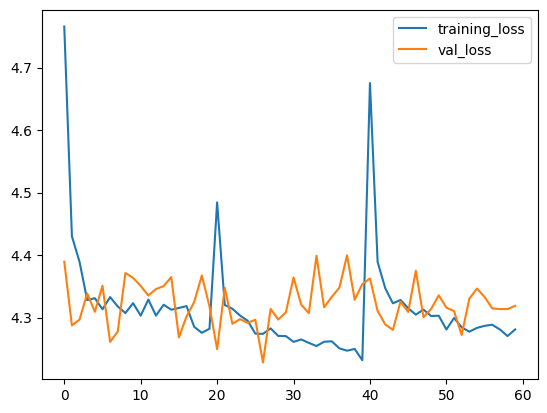

In [134]:
loss_data_framework.plot()

In [102]:
forecast = list(forecast_it)
tss = list(ts_it)

In [103]:
forecast_entry = forecast[0]
ts_entry = tss[0]

In [104]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 338)
Start date of the forecast window: 2019-12-02
Frequency of the time series: <Day>


In [160]:
forecast_entry.samples.shape

(100, 338)

In [159]:
test_entry['target'][-prediction_length:].shape

(338,)

In [141]:
print(ts_entry)

                    0
2011-07-29   6.249457
2011-07-30  28.978653
2011-07-31  37.209164
2011-08-01   5.041244
2011-08-02   4.197217
...               ...
2020-10-30  25.440001
2020-10-31  15.122000
2020-11-01  44.382999
2020-11-02   0.000000
2020-11-03   6.545000

[3386 rows x 1 columns]


In [166]:
time_series_original = pd.DataFrame(ts_entry)
time_series_original.columns = ['true_value']
time_series_original.to_csv("time_series_original_no_missing_values.csv")

In [170]:
predicted_values = "predicted_values_model_{}.csv".format(get_model_name(estimator))
predicted_values_100_series = pd.DataFrame(forecast_entry.samples.T)
predicted_values_100_series.to_csv(predicted_values)

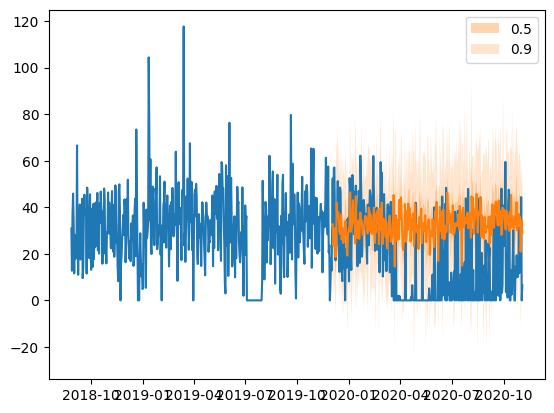

In [108]:
plt.plot(ts_entry[-800:].to_timestamp())
forecast_entry.plot(show_label=True)
plt.legend()

In [172]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecast)

Running evaluation: 0it [00:00, ?it/s]

Running evaluation: 1it [00:00,  4.74it/s]


In [180]:
print("Evaluation metrics: {}".format(get_model_name(estimator)))
agg_metrics_data_frame = pd.DataFrame([agg_metrics])

agg_metrics_csv_name = "agg_metrics_{}.csv".format(get_model_name(estimator))
agg_metrics_data_frame.to_csv(agg_metrics_csv_name)
agg_metrics_data_frame

Evaluation metrics: simple_feedforward


,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.1],...,RMSE,NRMSE,ND,wQuantileLoss[0.1],wQuantileLoss[0.5],wQuantileLoss[0.9],mean_absolute_QuantileLoss,mean_wQuantileLoss,MAE_Coverage,OWA
0,589.16226,7101.953125,5782.362305,17.107581,15.292116,1.374021,2.324417,1.077436,7.148672,4315.134051,...,24.272665,1.418825,1.22821,0.746258,1.22821,0.443363,4660.256811,0.805943,0.455621,NaN


In [271]:
agg_metrics["MSE"]

160.419390625

In [272]:
item_metrics.head()

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,None,2019-06-23,160.419391,4740.871582,10153.210938,20.306422,15.414398,0.615122,0.73717,0.923483,0.466933,7.01812,2077.793226,0.208,4740.871826,0.486,3412.612081,0.734


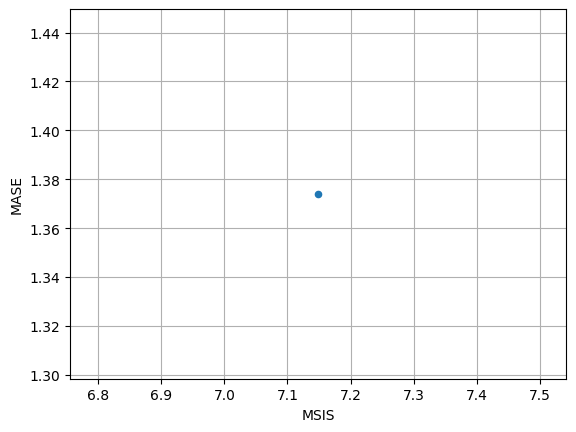

In [181]:
item_metrics.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()

#### Save existing model

In [182]:
# save the trained model in tmp/
from pathlib import Path
predictor.serialize(Path("/tmp/"))

# loads it back
from gluonts.model.predictor import Predictor
predictor_deserialized = Predictor.deserialize(Path("/tmp/"))